# TEMPORAL VARIANCE

In [6]:
"""
combined dataset is a dictionary of the format
key: document id
value: dictionary
       key1 (doc_text): text of the document
       value1: dictionary of the probability distribution of words in the document
       key2 (doc_summ): the original headline summary of the document
       value2: dictionary of the probability distribution of words in the original headline summary
       key3 (u_dict): user written summary
       value3: dictionary of userids and their user written summaries
               keys (NT1): user ids
               values: distribution of words in the user written summary
       key4 (m_dict): dictionary of model ids and their corresponding model generated summaries for each user id
       value4: dictionary of model ids
               keys (NRMS_1): model ids/ model names
               values: dictionary of user ids and their model generated summary
                       keys (NT1): user ids
                       values: model generated summaries corresponding to user ids
       key5 (vocab): vocabulary of all the words from the document and summaries
       value5: list of words in the vocabulary
"""

import pickle
with open('combined_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [3]:
"""
Dictionary: news_docs
    key: document ID
    value: text of the document
"""
news_docs = {}
for docid in dataset.keys():
    news_docs[docid] = dataset[docid]['doc_text']

In [8]:
"""
dct_tv is a dictionary of the format
    key (NT1): user id
    value: dictionary of the user written and model generated summaries
            key1 (u_summ): user written summaries
            value1: dictionary
                    keys: document ids
                    values: user written summaries
            key2 (m_summ): model generated summaries
            value2: dictionary
                    keys: model ids/ model names
                    values: dictionary
                            keys: document ids
                            values: model generated summaries
"""

dct_tv = {}

for doc_id in dataset:
    for uid in dataset[doc_id]['u_dict'].keys():
        if uid not in dct_tv.keys():
            dct_tv[uid] = {'u_summ':{}, 'm_summ':{'NRMS_1':{}, 'NRMS_2':{}, 'NAML_1':{}, 'EBNR_1':{}, 'EBNR_2':{}}}
        
        dct_tv[uid]['u_summ'][doc_id] = dataset[doc_id]['u_dict'][uid]
        dct_tv[uid]['m_summ']['NRMS_1'][doc_id] = dataset[doc_id]['m_dict']['NRMS_1'][uid]
        dct_tv[uid]['m_summ']['NRMS_2'][doc_id] = dataset[doc_id]['m_dict']['NRMS_2'][uid]
        dct_tv[uid]['m_summ']['NAML_1'][doc_id] = dataset[doc_id]['m_dict']['NAML_1'][uid]
        dct_tv[uid]['m_summ']['EBNR_1'][doc_id] = dataset[doc_id]['m_dict']['EBNR_1'][uid]
        dct_tv[uid]['m_summ']['EBNR_2'][doc_id] = dataset[doc_id]['m_dict']['EBNR_2'][uid]
        

Angle of Deviation

In [1]:
import numpy as np
from scipy.special import softmax, kl_div
from collections import OrderedDict
import copy
def jsd(p, q):
  """
  Jenson Shannen Divergence between distribution p and distribution q is returned
  """
  combined_vocab = set()

  for words in p.keys():
    combined_vocab.add(words)
  for words in q.keys():
    combined_vocab.add(words)

  combined_vocab = list(combined_vocab)
  orderd_combined_vocab = OrderedDict()

  orderd_combined_vocab = {word:0 for word in combined_vocab}

  new_p = copy.deepcopy(orderd_combined_vocab)
  new_q = copy.deepcopy(orderd_combined_vocab)

  for word in p.keys():
    new_p[word] = p[word]
  for word in q.keys():
    new_q[word] = q[word]

  
  p = list(new_p.values())
  q = list(new_q.values())
  p, q = np.asarray(p), np.asarray(q)
    
  if p.sum():
        p = p/p.sum()

  if q.sum():
      q = q/q.sum()

  m = 0.5 * (p + q)
  return 0.5 * sum(kl_div(p, m)) + 0.5 * sum(kl_div(q, m))

In [2]:
def calc_aod(lst):
    """
    this function calculate the angle of deviation between two summaries in a given time interval
    """
    theta_list = []
    for i in range(len(lst) - 1):
        b = jsd(lst[i][0], lst[i][1])   #d1, u1
        c = jsd(lst[i][0], lst[i+1][1])   #d1, u2
        a = jsd(lst[i][1], lst[i+1][1])   #u1, u2                      
        d = jsd(lst[i][0], lst[i+1][0])   #d1, d2
        e = jsd(lst[i+1][0], lst[i+1][1]) #d2, u2
        
        theta = np.arccos((b*b + c*c - a*a)/(2*b*c))
        alpha = np.arccos((c*c + e*e - d*d)/(2*c*e))
        
        theta_list.append(theta+alpha)
        
    return theta_list

In [3]:
def calc_rate_of_change(w):
    """
    rate of change of angular speed of deviation in summaries is calculated
    """
    alpha = []
    for i in range(len(w) - 1):
        alpha.append(abs(w[i+1] - w[i])/2)
        
    return alpha

In [5]:
def find_dev_sum(alpha_u, alpha_s, dev_per_gr):
    """
    finds the deviation sum
    """
    sum1 = 0

    for i in range(len(alpha_u)):
        dev_per_gr[i] = min(alpha_u[i], alpha_s[i])/max(alpha_u[i], alpha_s[i])
        sum1 += min(alpha_u[i], alpha_s[i])/max(alpha_u[i], alpha_s[i])
        
    return sum1
        

In [9]:
def find_e_dins_tv(model_name, dct_tv, news_docs):
    edins_user_dct = {} #records edins wrt tv for each user
    dev_per_uid = {} #records deviation of each user
    for uid in dct_tv:
        list1 = []
        list2 = []
        for docid in dct_tv[uid]['m_summ'][model_name].keys():
            list1.append((news_docs[docid], dct_tv[uid]['u_summ'][docid]))
            list2.append((news_docs[docid], dct_tv[uid]['m_summ'][model_name][docid]))

        aod_u = calc_aod(list1)
        aod_s = calc_aod(list2)

        #since the time interval is considered constant and 1 we directly pass the angle of deviation
        #to the function calculating rate of change of angular speed
        
        alpha_u = calc_rate_of_change(aod_u)
        alpha_s = calc_rate_of_change(aod_s)
        
        dev_per_gr = {}
        dev_sum = find_dev_sum(alpha_u, alpha_s, dev_per_gr)
        
        edins_tv = 1 - (dev_sum/len(alpha_u))
        
        edins_user_dct[uid] = edins_tv
    
        dev_per_uid[uid] = dev_per_gr
        
    sum1 = 0
    nans = 0
    for key in edins_user_dct.keys():
        if math.isnan(edins_user_dct[key]):
            print(key)
            nans += 1
        else:
            sum1 += edins_user_dct[key]
        
        e_dins_tv = 1 - sum1/(len(edins_user_dct)-nans)

    return dev_per_uid, e_dins_tv , edins_user_dct

        

RESULTS

In [39]:
import math
edins_tv_dict = {}

edins_tv_dict['NRMS_1'], edins_nrms1, edins_user_dct_nrms1 = find_e_dins_tv('NRMS_1', dct_tv, news_docs)
edins_tv_dict['NRMS_2'], edins_nrms2, edins_user_dct_nrms2 = find_e_dins_tv('NRMS_2', dct_tv, news_docs)
edins_tv_dict['NAML_1'], edins_naml1, edins_user_dct_naml1 = find_e_dins_tv('NAML_1', dct_tv, news_docs)
edins_tv_dict['EBNR_1'], edins_ebnr1, edins_user_dct_ebnr1 = find_e_dins_tv('EBNR_1', dct_tv, news_docs)
edins_tv_dict['EBNR_2'], edins_ebnr2, edins_user_dct_ebnr2 = find_e_dins_tv('EBNR_2', dct_tv, news_docs)


/tmp/ipykernel_151088/1837591451.py:11: RuntimeWarning: invalid value encountered in arccos
  alpha = np.arccos((c*c + e*e - d*d)/(2*c*e))
/tmp/ipykernel_151088/1837591451.py:10: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((b*b + c*c - a*a)/(2*b*c))


In [40]:
print(edins_nrms1)
print(edins_nrms2)
print(edins_naml1)
print(edins_ebnr1)
print(edins_ebnr2)

0.5347867711869287
0.532909344411159
0.533751196941079
0.5329998793183635
0.5359648600104909


ROUGE SCORE CALCULATION

In [14]:
import pickle
!pip install rouge-score
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

In [10]:
"""
5 model dataset contains doc id, doc text, original headline, 
user written summaries of each user and corresponding model generated summaries
"""

import json

f_name = open("5-model-dataset.json")
dataset = json.load(f_name)

In [16]:
def find_rouge(model_id, dataset, dct_tv):
    """
    rouge score calculation of user written and corressponding model generated summaries
    """
    rouge_dict = {} #key: uid;  value: rouge
    for uid in dct_tv.keys():
        rougel = 0

        for docid in dct_tv[uid]['u_summ'].keys():
                u_summ = dataset[docid]['u_dict'][uid]
                m_summ = dataset[docid]['m_dict'][model_id][uid]
                rougel += scorer.score(u_summ, m_summ)['rougeL'][2]

        rougel = rougel / (len(list(dct_tv[uid]['u_summ'].keys())))
        rouge_dict[uid] = rougel
        
    return rouge_dict

rouge_dict_nrms1 = find_rouge('1', dataset, dct_tv)
rouge_dict_naml1 = find_rouge('2', dataset, dct_tv)
rouge_dict_ebnr1 = find_rouge('3', dataset, dct_tv)
rouge_dict_nrms2 = find_rouge('4', dataset, dct_tv)
rouge_dict_ebnr2 = find_rouge('6', dataset, dct_tv)
    

calculating personalized rouge

In [27]:
personalized_rouge_nrms1 = {}
personalized_rouge_naml1 = {}
personalized_rouge_ebnr1 = {}
personalized_rouge_nrms2 = {}
personalized_rouge_ebnr2 = {}

alpha = 0.5
beta = 1
from scipy.special import softmax
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

for uid in edins_tv_dict['NAML_1'].keys():
    personalized_rouge_nrms1[uid] = rouge_dict_nrms1[uid] * (1 - (alpha * sigmoid((beta*edins_user_dict['NRMS_1'][uid])/rouge_dict_nrms1[uid]))) if rouge_dict_nrms1[uid] else 0
    
    personalized_rouge_naml1[uid] = rouge_dict_naml1[uid] * (1 - (alpha * sigmoid((beta*edins_user_dct[uid])/rouge_dict_naml1[uid]))) if rouge_dict_naml1[uid] else 0
    
    personalized_rouge_ebnr1[uid] = rouge_dict_ebnr1[uid] * (1 - (alpha * sigmoid((beta*edins_user_dict['EBNR_1'][uid])/rouge_dict_ebnr1[uid]))) if rouge_dict_ebnr1[uid] else 0
    
    personalized_rouge_nrms2[uid] = rouge_dict_nrms2[uid] * (1 - (alpha * sigmoid((beta*edins_user_dict['NRMS_2'][uid])/rouge_dict_nrms2[uid]))) if rouge_dict_nrms2[uid] else 0
    
    personalized_rouge_ebnr2[uid] = rouge_dict_ebnr2[uid] * (1 - (alpha * sigmoid((beta*edins_user_dict['EBNR_2'][uid])/rouge_dict_ebnr2[uid]))) if rouge_dict_ebnr1[uid] else 0

# Correlation between P-Rouge and Rouge

NRMS 1

In [ ]:
user_pair_score_dct = {}

for uid in personalized_rouge_nrms1.keys():
    user_pair_score_dct[uid] = [rouge_dict_nrms1[uid], personalized_rouge_nrms1[uid]]

In [ ]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='pearson')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + NRMS : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

NAML 1

In [28]:
user_pair_score_dct = {}

for uid in personalized_rouge_naml1.keys():
    user_pair_score_dct[uid] = [rouge_dict_naml1[uid], personalized_rouge_naml1[uid]]

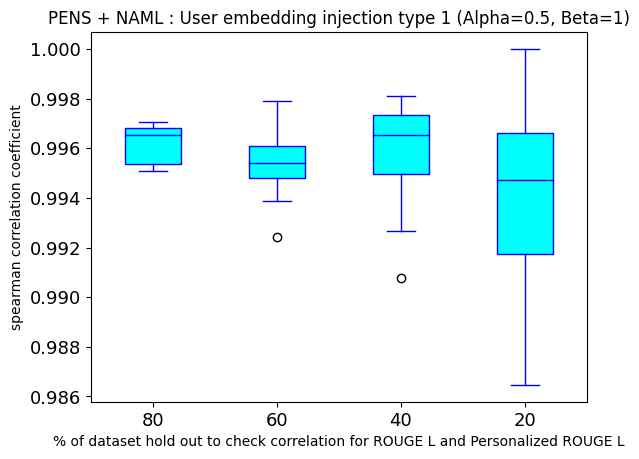

In [31]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='spearman'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='spearman')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('spearman correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

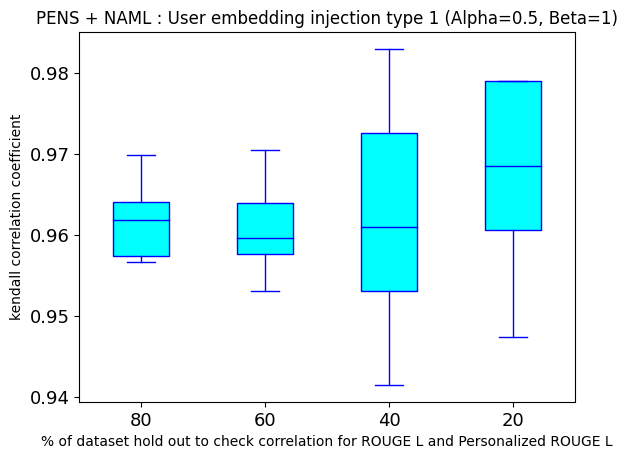

In [32]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='kendall'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='kendall')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('kendall correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

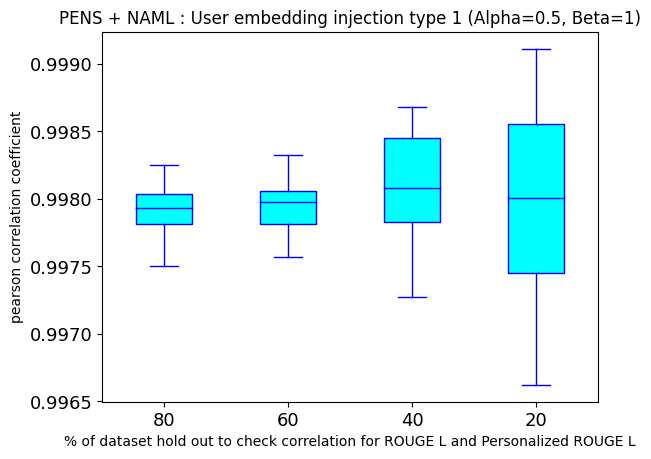

In [33]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='pearson')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('pearson correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

EBNR 1

In [ ]:
user_pair_score_dct = {}

for uid in personalized_rouge_ebnr1.keys():
    user_pair_score_dct[uid] = [rouge_dict_ebnr1[uid], personalized_rouge_ebnr1[uid]]

In [ ]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='pearson')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + EBNR : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

# Correlation ROUGE vs eDINS

In [34]:
rouge_edins_correlation_rouge = {}

for uid in dct_tv.keys():
    lstu, lsts = [], []
    for docid in dct_tv[uid]['u_summ'].keys():
        
        lstu.append(dataset[docid]['u_dict'][uid])
        lsts.append(dataset[docid]['m_dict']['2'][uid])
    
    rouge_edins_correlation_rouge[uid] = {}
    for i in range(len(lsts)):
        if i+2 < len(dct_tv[uid]['u_summ']):
            u1_summ = lstu[i]
            u2_summ = lstu[i+1]
            u3_summ = lstu[i+2]
            m1_summ = lsts[i]
            m2_summ = lsts[i+1]
            m3_summ = lsts[i+2]
            
            r1 = scorer.score(u1_summ, u2_summ)['rougeL'][2]
            r2 = scorer.score(u2_summ, u3_summ)['rougeL'][2]
            
            r3 = scorer.score(m1_summ, m2_summ)['rougeL'][2]
            r4 = scorer.score(m2_summ, m3_summ)['rougeL'][2]
            
            R1 = (1 - r1 + 1 - r2)/2
            R2 = (1 - r3 + 1 - r4)/2
            
            
            rouge_edins_correlation_rouge[uid][i] = min(R1, R2)/max(R1, R2) if max(R1,R2)!=0 else 0
            


In [ ]:
list(edins_naml3.items())

In [35]:
NAML_rouge_edins_propotion = {}
i = 0

for uid in rouge_edins_correlation_rouge:
    for key in rouge_edins_correlation_rouge[uid].keys():
        NAML_rouge_edins_propotion[i] = [edins_tv_dict['NAML_1'][uid][key], rouge_edins_correlation_rouge[uid][key]]
        i+=1

In [36]:
NAML_rouge_edins_propotion_lst = [ [pair, NAML_rouge_edins_propotion[pair][0], NAML_rouge_edins_propotion[pair][1]] for pair in NAML_rouge_edins_propotion]
NAML_rouge_edins_propotion_lst[0:2]

[[0, 0.16034841348431975, 0.9244444444444445], [1, 0.20975301584946018, 0.96]]

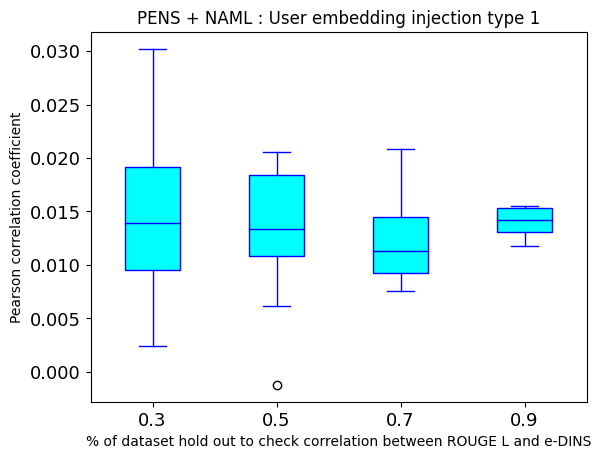

In [38]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, pairs):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(pairs) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []

    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            e_DINS_lst, r1_lst, r2_lst, rl_lst = [], [], [], []
            # for i in range(0, 5): # collect distb using 5 differnt rouge set to calculate co rel
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              rl_lst.append(pairs[idx][1])
              e_DINS_lst.append(pairs[idx][2])
                
            correl = find_corr(e_DINS_lst, rl_lst, method='pearson')
            correl_rl_lst.append(correl)
            
        # per_wise_correl_r1_lst.append(correl_r1_lst)
        # per_wise_correl_r2_lst.append(correl_r2_lst)
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.30, 0.50, 0.70, 0.90]#, 2000, 2500, 3000, 3500]
plot_data_pearson = box_plot_data2(percent_data_lst, NAML_rouge_edins_propotion_lst)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], percent_data_lst)

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation between ROUGE L and e-DINS', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1')
plt.show()

In [ ]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='kendall'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, pairs):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(pairs) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []

    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            e_DINS_lst, r1_lst, r2_lst, rl_lst = [], [], [], []
            # for i in range(0, 5): # collect distb using 5 differnt rouge set to calculate co rel
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              rl_lst.append(pairs[idx][1])
              e_DINS_lst.append(pairs[idx][2])
                
            correl = find_corr(e_DINS_lst, rl_lst, method='kendall')
            correl_rl_lst.append(correl)
            
        # per_wise_correl_r1_lst.append(correl_r1_lst)
        # per_wise_correl_r2_lst.append(correl_r2_lst)
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.30, 0.50, 0.70, 0.90]#, 2000, 2500, 3000, 3500]
plot_data_pearson = box_plot_data2(percent_data_lst, NAML_rouge_edins_propotion_lst)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], percent_data_lst)

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation between ROUGE L and e-DINS', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1')
plt.show()

In [ ]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='spearman'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, pairs):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(pairs) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []

    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            e_DINS_lst, r1_lst, r2_lst, rl_lst = [], [], [], []
            # for i in range(0, 5): # collect distb using 5 differnt rouge set to calculate co rel
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              rl_lst.append(pairs[idx][1])
              e_DINS_lst.append(pairs[idx][2])
                
            correl = find_corr(e_DINS_lst, rl_lst, method='spearman')
            correl_rl_lst.append(correl)
            
        # per_wise_correl_r1_lst.append(correl_r1_lst)
        # per_wise_correl_r2_lst.append(correl_r2_lst)
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.30, 0.50, 0.70, 0.90]#, 2000, 2500, 3000, 3500]
plot_data_pearson = box_plot_data2(percent_data_lst, NAML_rouge_edins_propotion_lst)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], percent_data_lst)

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation between ROUGE L and e-DINS', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1')
plt.show()